# Simple example of group convolutions with GroCo on MNIST

**author**: Aron Jansen

This notebook is to illustrate how to use GroCo for group convolutions.
For simplicity we'll use MNIST, but note that this is far from an ideal application, as the orientation of digits has significant meaning.
So don't take this as an illustration of their performance.

In [1]:
!git clone https://github.com/APJansen/groco groco
%cd groco

import tensorflow as tf
from tensorflow import keras
import numpy as np

Cloning into 'groco'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 226 (delta 101), reused 125 (delta 47), pack-reused 0
Receiving objects: 100% (226/226), 902.27 KiB | 2.92 MiB/s, done.
Resolving deltas: 100% (101/101), done.
/content/groco


## Loading MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

input_shape = (28, 28, 1)
num_classes = 10

11501568/11490434 [==============================] - 0s 0us/step


## Define Models

First we'll define a simple regular CNN model to compare to.
To be able to immediately generalize this to a group-CNN model, we'll define a function that takes the actual layers as arguments.

In [3]:
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D

def build_model(conv_layer, pool_layer, invariant_layer, filters):
  model = Sequential([
                      Input(shape=input_shape),
                      conv_layer(kernel_size=3, activation='relu', filters=filters[0]),
                      conv_layer(kernel_size=3, activation='relu', filters=filters[1]),
                      pool_layer(strides=2, pool_size=2),
                      conv_layer(kernel_size=3, activation='relu', filters=filters[2]),
                      conv_layer(kernel_size=3, activation='relu', filters=filters[3]),
                      invariant_layer(),
                      Dense(num_classes, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['acc'])
  
  model.summary()

  return model

Now passing the regular layers, we obtain a regular CNN:

In [4]:
filters = [16, 32, 64, 128]
regular_CNN = build_model(Conv2D, MaxPooling2D, GlobalMaxPooling2D, filters)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

Now we load the group-convolution generalizations of these layers

In [5]:
from functools import partial
from groco.layers import GroupConv2D, GroupMaxPooling2D
from keras.layers import GlobalMaxPooling3D
from groco.groups.wallpaper_groups import P4M

P4MConv2D = partial(GroupConv2D, group='P4M')
P4MMaxPooling2D = partial(GroupMaxPooling2D, group='P4M')
P4Minvariant = GlobalMaxPooling3D

To obtain a model with roughly the same number of parameters, we divide the filters by the square root of the number of group elements.

In [6]:
reduced_filters = [round(filter / np.sqrt(P4M.order)) for filter in filters]

And then we simply pass these layers into the `build_model` function and we get a Group-CNN model:

In [7]:
p4m_CNN = build_model(P4MConv2D, P4MMaxPooling2D, P4Minvariant, reduced_filters)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
group_conv2d (GroupConv2D)   (None, 26, 26, 8, 6)      60        
_________________________________________________________________
group_conv2d_1 (GroupConv2D) (None, 24, 24, 8, 11)     4763      
_________________________________________________________________
group_max_pooling2d (GroupMa (None, 12, 12, 8, 11)     0         
_________________________________________________________________
group_conv2d_2 (GroupConv2D) (None, 10, 10, 8, 23)     18239     
_________________________________________________________________
group_conv2d_3 (GroupConv2D) (None, 8, 8, 8, 45)       74565     
_________________________________________________________________
global_max_pooling3d (Global (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

Note the extra axis in the output shapes, this is the group axis.
Note also that while the reduction of filters we did made the number of parameters roughly equivalent, the number of outputs, if we merge the new group axis with the channel axis, is still a factor of roughly 3 (again the square root of the number of group elements) larger.

## Test invariance

The group-CNN model should be invariant to transformations of the input by the group p4m, let's test this:

In [8]:
test_image = x_train[2:3]
print('image shape: ', test_image.shape)
transformed_images = P4M.action(test_image, spatial_axes=(1, 2), new_group_axis=0)
print('transformed images shape: ', transformed_images.shape)

image shape:  (1, 28, 28, 1)
transformed images shape:  (8, 1, 28, 28, 1)


This has created a new axis corresponding to the elements of the group. We can merge this with the batch dimension so our models will just treat this as 8 different input images:

In [9]:
transformed_images = tf.reshape(transformed_images, (P4M.order,) + transformed_images.shape[2:])
print('new shape: ', transformed_images.shape)

new shape:  (8, 28, 28, 1)


In [10]:
regular_probabilities = regular_CNN(transformed_images)
p4m_probabilities = p4m_CNN(transformed_images)
regular_classes = tf.argmax(regular_probabilities, axis=1)
p4m_classes = tf.argmax(p4m_probabilities, axis=1)

print('Predicted classes by regular CNN: ', regular_classes)
print('Predicted classes by p4m CNN: ', p4m_classes)

Predicted classes by regular CNN:  tf.Tensor([4 4 4 4 4 4 4 4], shape=(8,), dtype=int64)
Predicted classes by p4m CNN:  tf.Tensor([8 8 8 8 8 8 8 8], shape=(8,), dtype=int64)


So the group CNN's class predictions are invariant, while the regular ones are not. But it's not very impressive, the regular ones are also almost invariant. The difference becomes clearer if we look at the probabilities themselves, in particular their difference with the original image:

In [11]:
regular_max_diff = tf.reduce_max(tf.abs(regular_probabilities - regular_probabilities[0])).numpy()
p4m_max_diff = tf.reduce_max(tf.abs(p4m_probabilities - p4m_probabilities[0])).numpy()
print('Maximal probability difference with original image for regular CNN: ', regular_max_diff)
print('Maximal probability difference with original image for p4m CNN: ', p4m_max_diff)

Maximal probability difference with original image for regular CNN:  0.0031654537
Maximal probability difference with original image for p4m CNN:  1.6391277e-07


So we can see clearly that the group CNN is really invariant, while the regular one is only approximately so, probably owing to the weights being small and the pixel values of the images still being the same (just at different locations).

## Training

Now let's train them to see how they compare in training time and accuracy.
We shouldn't expect the group CNN to outperform the regular one in this example, because MNIST is clearly not invariant to the group transformations. In particular a 180 degree rotation changes sixes into nines and vice versa.
And to keep the number of parameters roughly the same we had to divide the number of filters by the square root of the number of group elements, so this extra equivariance/invariance does not come for free.

In terms of training time, while the number of parameters is roughly the same, the number of output features at each layer is still bigger by a factor of the square root of the number of elements. So we should expect the group convolution to be roughly 3 times slower to train.

In [12]:
epochs = 15
batch_size = 128
validation_split = 0.1

In [13]:
regular_CNN.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/15
422/422 [==============================] - 8s 14ms/step - loss: 0.3003 - acc: 0.9110 - val_loss: 0.0994 - val_acc: 0.9693
Epoch 2/15
422/422 [==============================] - 6s 13ms/step - loss: 0.0800 - acc: 0.9757 - val_loss: 0.0595 - val_acc: 0.9830
Epoch 3/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0590 - acc: 0.9817 - val_loss: 0.0562 - val_acc: 0.9838
Epoch 4/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0425 - acc: 0.9870 - val_loss: 0.0691 - val_acc: 0.9807
Epoch 5/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0350 - acc: 0.9888 - val_loss: 0.0446 - val_acc: 0.9877
Epoch 6/15
422/422 [==============================] - 6s 13ms/step - loss: 0.0287 - acc: 0.9905 - val_loss: 0.0447 - val_acc: 0.9887
Epoch 7/15
422/422 [==============================] - 6s 13ms/step - loss: 0.0274 - acc: 0.9911 - val_loss: 0.0403 - val_acc: 0.9887
Epoch 8/15
422/422 [==============================] - 5s 13ms/step - 

In [14]:
p4m_CNN.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/15
422/422 [==============================] - 21s 45ms/step - loss: 0.6494 - acc: 0.7892 - val_loss: 0.2534 - val_acc: 0.9235
Epoch 2/15
422/422 [==============================] - 18s 43ms/step - loss: 0.2491 - acc: 0.9212 - val_loss: 0.2108 - val_acc: 0.9342
Epoch 3/15
422/422 [==============================] - 18s 43ms/step - loss: 0.1823 - acc: 0.9421 - val_loss: 0.1514 - val_acc: 0.9507
Epoch 4/15
422/422 [==============================] - 18s 44ms/step - loss: 0.1474 - acc: 0.9526 - val_loss: 0.1485 - val_acc: 0.9533
Epoch 5/15
422/422 [==============================] - 18s 44ms/step - loss: 0.1243 - acc: 0.9609 - val_loss: 0.1391 - val_acc: 0.9548
Epoch 6/15
422/422 [==============================] - 18s 44ms/step - loss: 0.1104 - acc: 0.9649 - val_loss: 0.1191 - val_acc: 0.9627
Epoch 7/15
422/422 [==============================] - 18s 43ms/step - loss: 0.0929 - acc: 0.9690 - val_loss: 0.1343 - val_acc: 0.9595
Epoch 8/15
422/422 [==============================] - 18s 43ms

In [15]:
regular_CNN.evaluate(x_test, y_test, batch_size=batch_size)
p4m_CNN.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 1s 16ms/step - loss: 0.1817 - acc: 0.9558


[0.18173040449619293, 0.9557999968528748]

As expected, the training time is roughly 3 times longer, and the accuracy slightly worse.

## Equivariance

To be sure it wasn't a fluke of the model not being trained, let's verify again that it is invariant.

In [16]:
regular_probabilities = regular_CNN(transformed_images)
p4m_probabilities = p4m_CNN(transformed_images)

regular_max_diff = tf.reduce_max(tf.abs(regular_probabilities - regular_probabilities[0])).numpy()
p4m_max_diff = tf.reduce_max(tf.abs(p4m_probabilities - p4m_probabilities[0])).numpy()

print('Maximal probability difference with original image for regular CNN: ', regular_max_diff)
print('Maximal probability difference with original image for p4m CNN: ', p4m_max_diff)

Maximal probability difference with original image for regular CNN:  0.98459953
Maximal probability difference with original image for p4m CNN:  2.2053719e-06


We can also verify that intermediate layers are equivariant with a built in utility function `test_equivariance`, which computes the maximal difference between first applying the group transformation and then the layer, or first applying the layer and then transforming the result.

In [17]:
from groco.utils import test_equivariance

regular_layer = regular_CNN.layers[0]
p4m_layer = p4m_CNN.layers[0]

p4m_diff = test_equivariance(p4m_layer, test_image)
regular_diff = test_equivariance(regular_layer, test_image, group_name='P4M')

print(f'Regular CNN layer equivariant to precision {regular_diff}')
print(f'Group CNN layer equivariant to precision {p4m_diff}')

Regular CNN layer equivariant to precision 1.0009435415267944
Group CNN layer equivariant to precision 2.384185791015625e-07


So this layer is equivariant for the group CNN, as we could have expected from the invariance of the full model, and it is not for the regular CNN.

It is also nice to visualize this. To do so we feed the transformed images into both layers. For the group-convolutional layer, its equivariance means that 

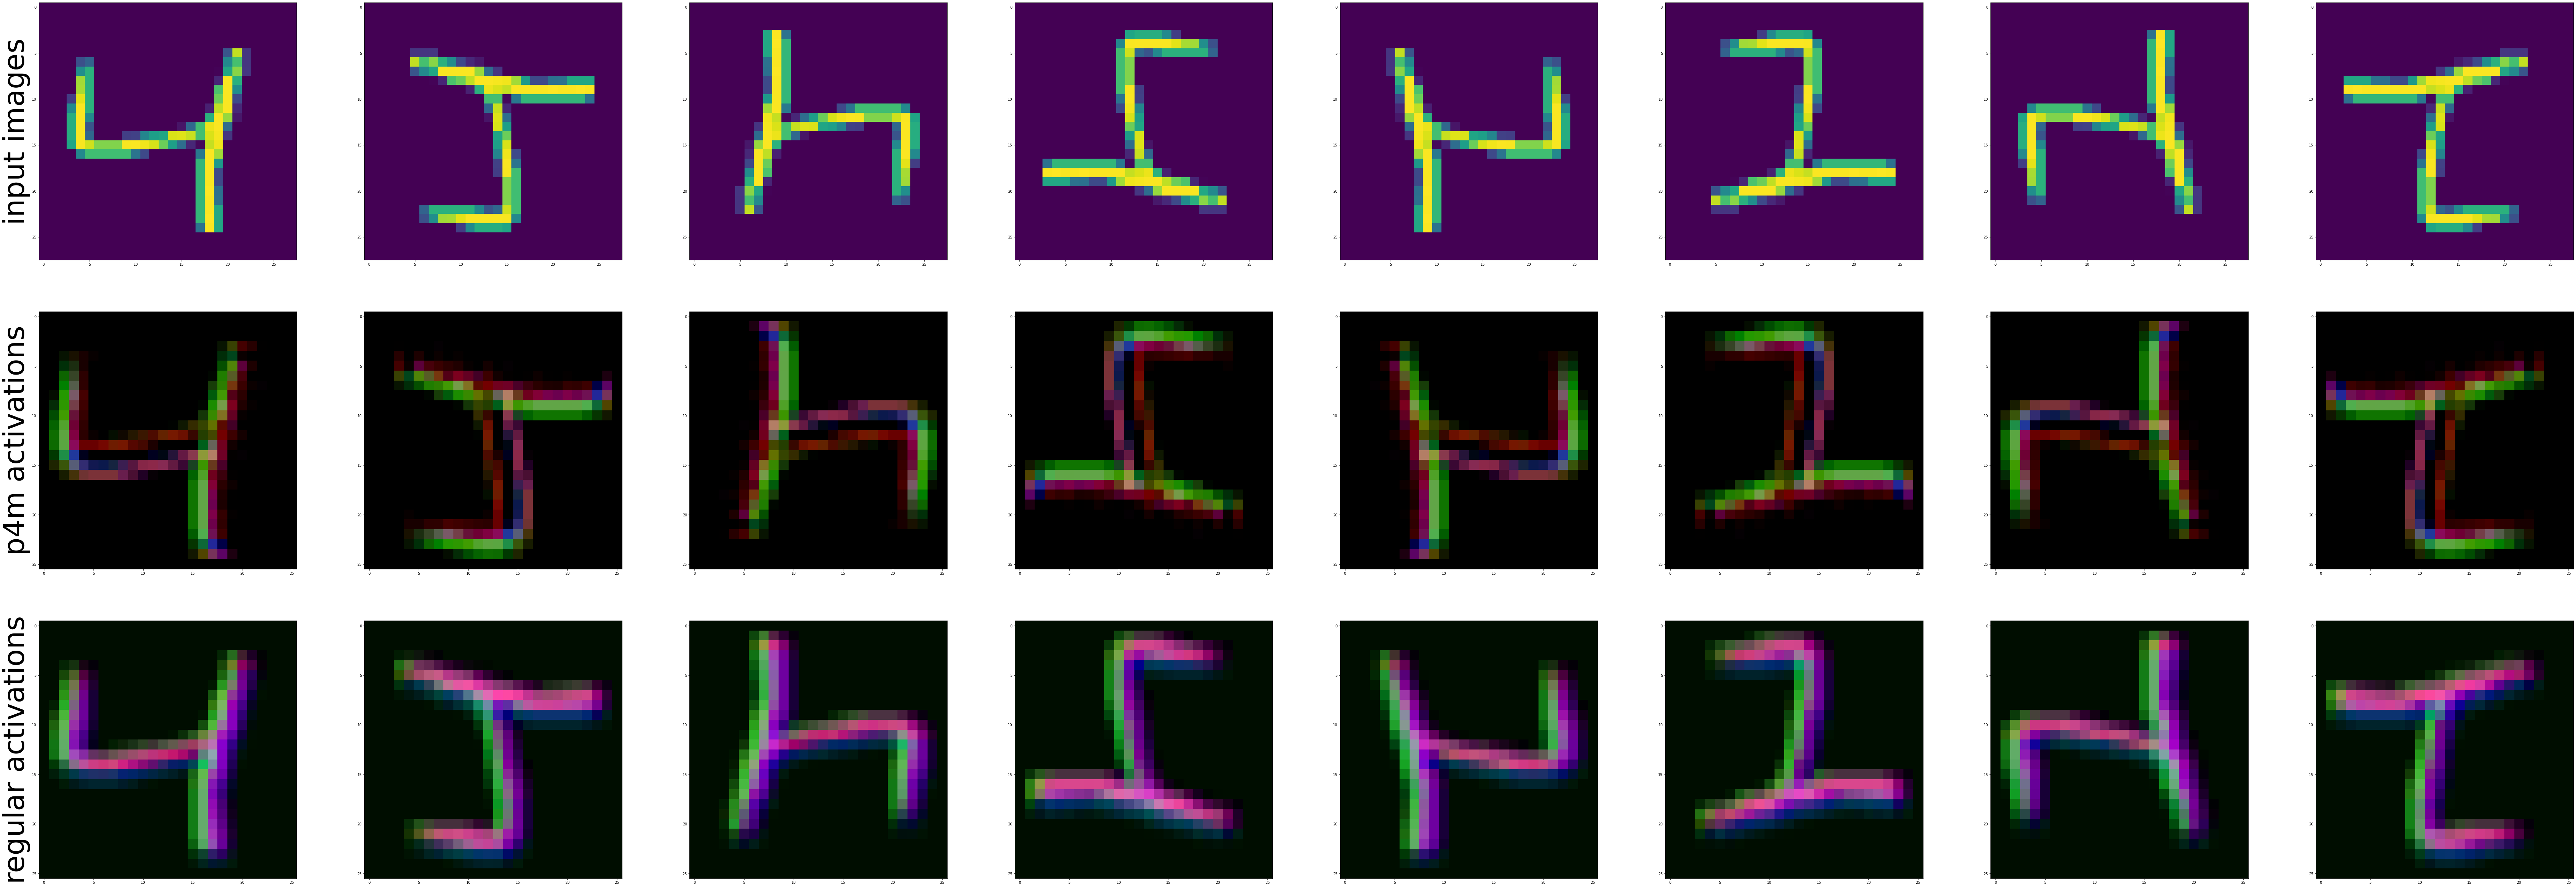

In [18]:
from matplotlib import pyplot as plt

regular_images = regular_layer(transformed_images)
p4m_images = p4m_layer(transformed_images)

fig, axes = plt.subplots(3, P4M.order)
fig.set_figheight(3 * 15)
fig.set_figwidth((P4M.order + .5) * 15)
gi = 3 # to visualize the output, just arbitrarily pick one group element 
ci = 2 # and one channel element
for i in range(P4M.order):
  axes[0, i].imshow(transformed_images[i][:, :, 0])
  axes[1, i].imshow(p4m_images[i][:, :, i, ci:ci + 3])
  axes[2, i].imshow(regular_images[i][:, :, ci:ci + 3])
  
axes[0, 0].set_ylabel('input images', fontsize=80)
axes[1, 0].set_ylabel('p4m activations', fontsize=80)
axes[2, 0].set_ylabel('regular activations', fontsize=80)

fig.show()

In both cases the hidden features are similar to the transformed input image above it. This is simply because of the translation invariance and locality that both layers posses. However if one looks closely at the regular CNN's activations, the colors don't rotate along with the shape, while for the group CNN's layer they do.

## Subgroups

Rather than keeping the same group throughout, we can start with the biggest group p4m of 90 degree rotations and reflections at the first layer, and gradually pool onto subgroups. For example remove the rotations, leaving only horizontal and vertical reflections, and at a higher layer only leave horizontal reflections.

The idea would be that for example the edges detected at lower layers may occur in any orientation, so it can be advantageous to use filters that are equivariant to their orientation. But higher level features have different meanings depending on the orientation of these lower level features. Here we simply max pool over the cosets of the subgroup. (It might also be interesting to keep everything but merge these cosets with the channel axis)

In [19]:
from functools import partial
from groco.groups.wallpaper_groups import group_dict

def gc_layer(group, next_group, filters):
  return GroupConv2D(group=group, kernel_size=3, activation='relu',
                     filters=round(filters // np.sqrt(group_dict[next_group].order)))
  
def build_model_subgroups(filters, groups):
  model = Sequential([
                      Input(shape=input_shape),
                      gc_layer(groups[0], groups[0], filters[0]),
                      gc_layer(groups[0], groups[1], filters[1]),
                      GroupMaxPooling2D(strides=2, pool_size=2, 
                                        group=groups[0], subgroup=groups[1]),
                      gc_layer(groups[1], groups[2], filters[2]),
                      GroupMaxPooling2D(strides=1, pool_size=1, 
                                        group=groups[1], subgroup=groups[2]),                      
                      gc_layer(groups[2], groups[2], filters[3]),
                      GlobalMaxPooling3D(),
                      Dense(num_classes, activation='softmax')
  ])
                      
  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['acc'])
  
  model.summary()

  return model

In [20]:
subgroup_CNN = build_model_subgroups(filters=filters, groups=['P4M', 'P2MM', 'PMw'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
group_conv2d_4 (GroupConv2D) (None, 26, 26, 8, 5)      50        
_________________________________________________________________
group_conv2d_5 (GroupConv2D) (None, 24, 24, 8, 16)     5776      
_________________________________________________________________
group_max_pooling2d_1 (Group (None, 12, 12, 4, 16)     0         
_________________________________________________________________
group_conv2d_6 (GroupConv2D) (None, 10, 10, 4, 45)     25965     
_________________________________________________________________
group_max_pooling2d_2 (Group (None, 10, 10, 2, 45)     0         
_________________________________________________________________
group_conv2d_7 (GroupConv2D) (None, 8, 8, 2, 90)       72990     
_________________________________________________________________
global_max_pooling3d_1 (Glob (None, 90)               

In [21]:
subgroup_CNN.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/15
422/422 [==============================] - 20s 43ms/step - loss: 0.4002 - acc: 0.8707 - val_loss: 0.1224 - val_acc: 0.9633
Epoch 2/15
422/422 [==============================] - 18s 42ms/step - loss: 0.1058 - acc: 0.9668 - val_loss: 0.0792 - val_acc: 0.9748
Epoch 3/15
422/422 [==============================] - 18s 42ms/step - loss: 0.0744 - acc: 0.9764 - val_loss: 0.0688 - val_acc: 0.9788
Epoch 4/15
422/422 [==============================] - 18s 42ms/step - loss: 0.0538 - acc: 0.9826 - val_loss: 0.0616 - val_acc: 0.9818
Epoch 5/15
422/422 [==============================] - 18s 42ms/step - loss: 0.0459 - acc: 0.9845 - val_loss: 0.0501 - val_acc: 0.9855
Epoch 6/15
422/422 [==============================] - 18s 42ms/step - loss: 0.0382 - acc: 0.9873 - val_loss: 0.0607 - val_acc: 0.9827
Epoch 7/15
422/422 [==============================] - 18s 42ms/step - loss: 0.0299 - acc: 0.9901 - val_loss: 0.0655 - val_acc: 0.9815
Epoch 8/15
422/422 [==============================] - 18s 42ms

In [22]:
subgroup_CNN.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 1s 13ms/step - loss: 0.0627 - acc: 0.9825


[0.06270769238471985, 0.9825000166893005]

Now the network is no longer invariant to the largest group p4m at the first layer, but it still maintains equivariance to the smallest group at the final layer. This subgroup consists of the first element (the identity) and the one at index 4 of the full group.

In [23]:
subgroup_probabilities = subgroup_CNN(transformed_images)
subgroup_equivs = tf.reduce_max(tf.abs(subgroup_probabilities - subgroup_probabilities[0]), axis=1).numpy()
print(subgroup_equivs)
print(subgroup_equivs[4])

[0.0000000e+00 9.9914771e-01 9.9452621e-01 9.9836886e-01 1.9092113e-08
 9.9836886e-01 9.9452621e-01 9.9914771e-01]
1.9092113e-08
